### This notebook aims to plot the results

In [203]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import json
from dotenv.main import load_dotenv
import os
from datetime import datetime

load_dotenv(override=True)

True

In [204]:
df = pd.read_csv('../../data/final_asset_classes.csv', index_col=0)
df.index = pd.to_datetime(df.index)

In [205]:
df.head()

,FTSE EPRA Nareit Developed Europe TRI,LPX50PE,MSCI World,ICE BofA G0BC (Corporate World),FTSE EMU Government Bond (EGBI) TRI,ICE BofA HW00 (Global HY)
Date,,,,,,
2005-10-10,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2005-10-11,1.003231,1.006833,1.007047,0.998658,0.998084,0.995925
2005-10-12,0.999670,0.997110,0.999229,0.996056,0.996517,0.991573
2005-10-13,0.981077,0.986449,0.991452,0.993734,0.993465,0.988179
2005-10-14,0.973370,0.987997,0.995770,0.993174,0.993525,0.989778


In [206]:
start_date = os.getenv("END_TRAIN_DATE")
end_date = os.getenv("END_SIMULATION_DATE")
df = df[(df.index >= str(start_date)) & (df.index <= str(end_date))]

In [207]:
daily_returns = df.pct_change().dropna()

egbi_returns = daily_returns["FTSE EMU Government Bond (EGBI) TRI"]
cumulative_egbi_returns = (1 + egbi_returns).cumprod()

msci_returns = daily_returns['MSCI World']
cumulative_msci_returns = (1 + msci_returns).cumprod()

In [208]:
def load_portfolio_weights(json_file):
    """
    Load portfolio weights from the JSON file.
    """
    with open(json_file, 'r') as file:
        data = json.load(file)
    
    portfolios = []
    for entry in data:
        for solution in entry["solutions"]:
            portfolios.append(solution["weights"])
    return portfolios

In [209]:
def plot_results(portfolios, show_average_only=True):
    plt.figure(figsize=(14, 8))
    
    plt.plot(cumulative_egbi_returns.index, cumulative_egbi_returns, 
             label='FTSE EMU Government Bond (EGBI) TRI', linewidth=2, linestyle='--', color='black')

    plt.plot(cumulative_msci_returns.index, cumulative_msci_returns, 
             label='MSCI World', linewidth=2, linestyle='--', color='orange')
    
    if not show_average_only:
        for i, weights in enumerate(portfolios):
            portfolio_returns = daily_returns.dot(weights)
            cumulative_portfolio_returns = (1 + portfolio_returns).cumprod()

            plt.plot(cumulative_portfolio_returns.index, 
                cumulative_portfolio_returns, 
                label=f'Portfolio {i+1}', alpha=0.7)
    
    else:
        average_weights = np.mean(portfolios, axis=0)
        
        average_portfolio_returns = daily_returns.dot(average_weights)
        cumulative_average_returns = (1 + average_portfolio_returns).cumprod()
        
        plt.plot(cumulative_average_returns.index, 
                cumulative_average_returns, 
                label='Average Portfolio', linewidth=3, linestyle='-', color='blue')

    plt.title("Average Portfolio vs. FTSE EMU Government Bond (EGBI) TRI and MSCI World")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [210]:
def plot_volatility(portfolios, show_average_only=True, window=30):
    plt.figure(figsize=(14, 8))
    
    # Ensure daily returns are in the correct format
    global daily_returns

    # Calculate rolling volatility for the FTSE EMU Government Bond (EGBI) TRI
    egbi_volatility = daily_returns["FTSE EMU Government Bond (EGBI) TRI"].rolling(window).std()
    plt.plot(egbi_volatility.index, egbi_volatility, 
             label='FTSE EMU Government Bond (EGBI) TRI', linewidth=2, linestyle='--', color='black')

    # Calculate rolling volatility for MSCI World
    msci_volatility = daily_returns["MSCI World"].rolling(window).std()
    plt.plot(msci_volatility.index, msci_volatility, 
             label='MSCI World', linewidth=2, linestyle='--', color='orange')

    if not show_average_only:
        # Plot rolling volatility for each portfolio
        for i, weights in enumerate(portfolios):
            portfolio_returns = daily_returns.dot(weights)
            portfolio_volatility = portfolio_returns.rolling(window).std()
            
            plt.plot(portfolio_volatility.index, 
                     portfolio_volatility, 
                     label=f'Portfolio {i+1}', alpha=0.7)
    
    else:
        # Calculate average weights across all portfolios
        average_weights = np.mean(portfolios, axis=0)
        
        # Calculate returns for the average portfolio
        average_portfolio_returns = daily_returns.dot(average_weights)
        average_portfolio_volatility = average_portfolio_returns.rolling(window).std()
        
        # Plot the rolling volatility for the average portfolio
        plt.plot(average_portfolio_volatility.index, 
                 average_portfolio_volatility, 
                 label='Average Portfolio', linewidth=3, linestyle='-', color='blue')

    # Set plot aesthetics
    plt.title(f"Rolling {window}-Day Volatility vs. FTSE EMU Government Bond (EGBI) TRI and MSCI World")
    plt.xlabel("Date")
    plt.ylabel("Volatility (Standard Deviation)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


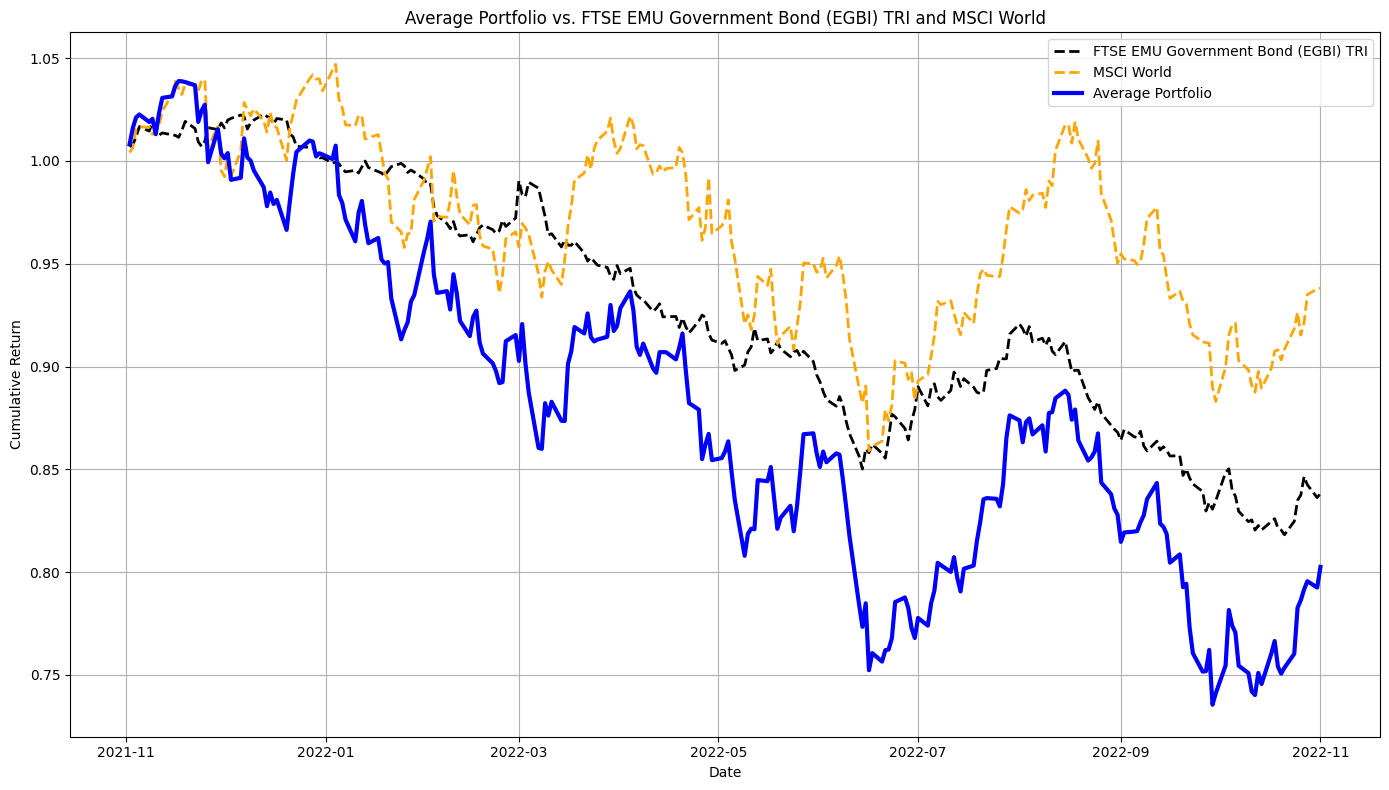

In [211]:
json_file_path = "../pareto_front_results.json"
portfolios = load_portfolio_weights(json_file_path)

# Plot results
plot_results(portfolios, show_average_only=True)

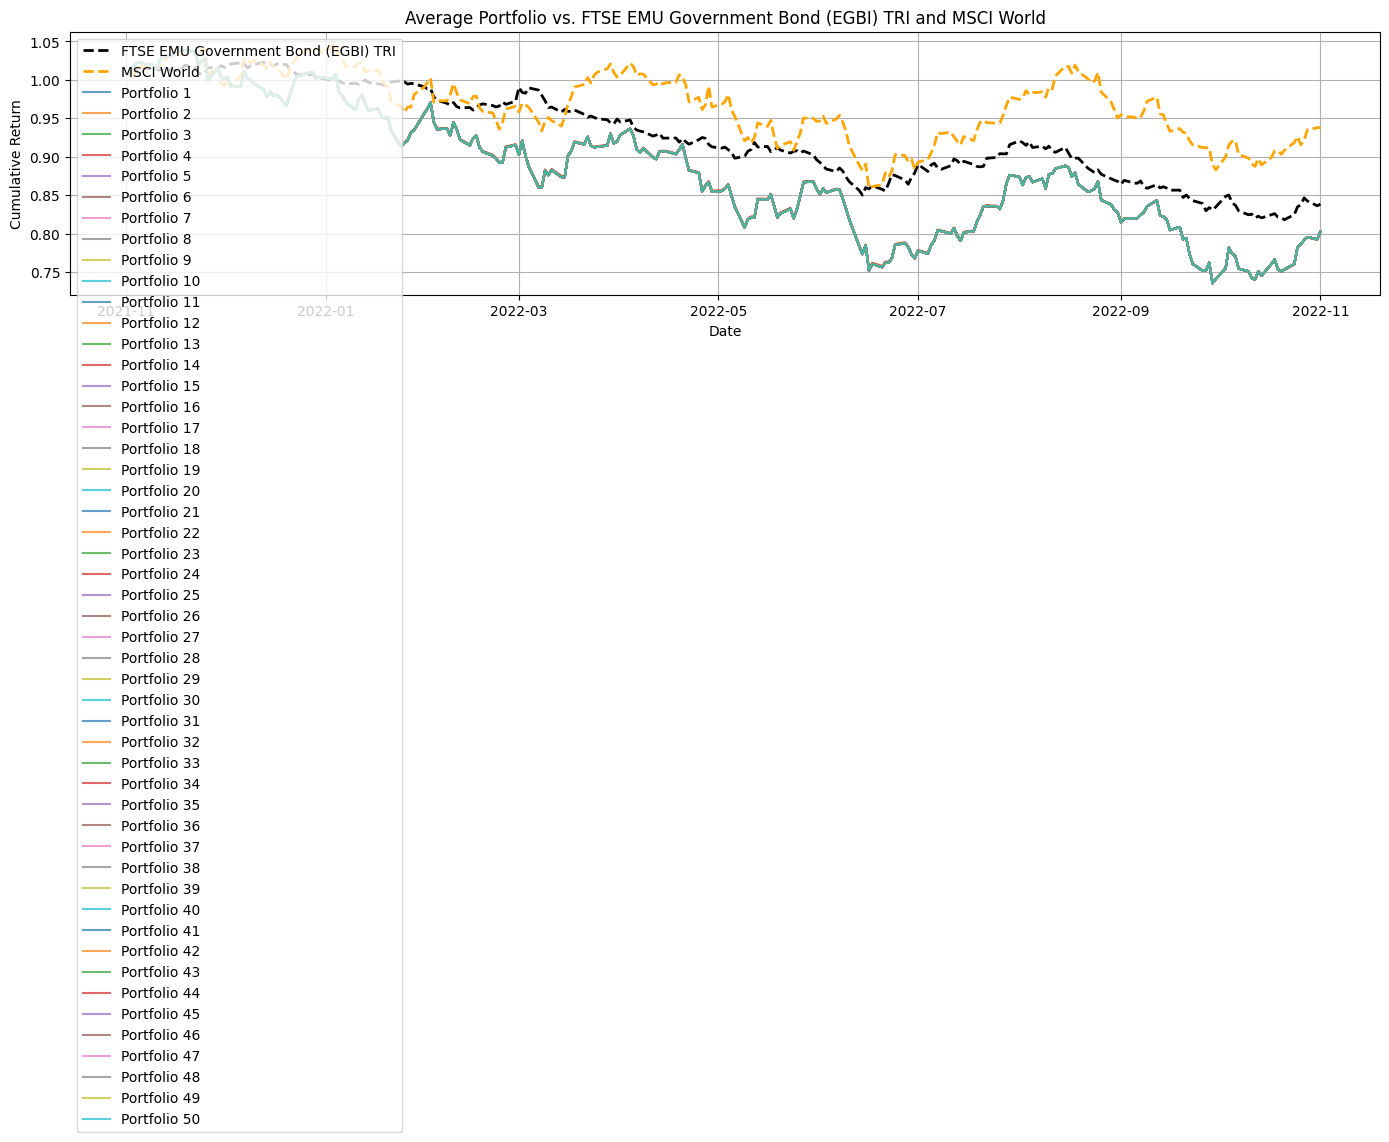

In [212]:
plot_results(portfolios, show_average_only=False)

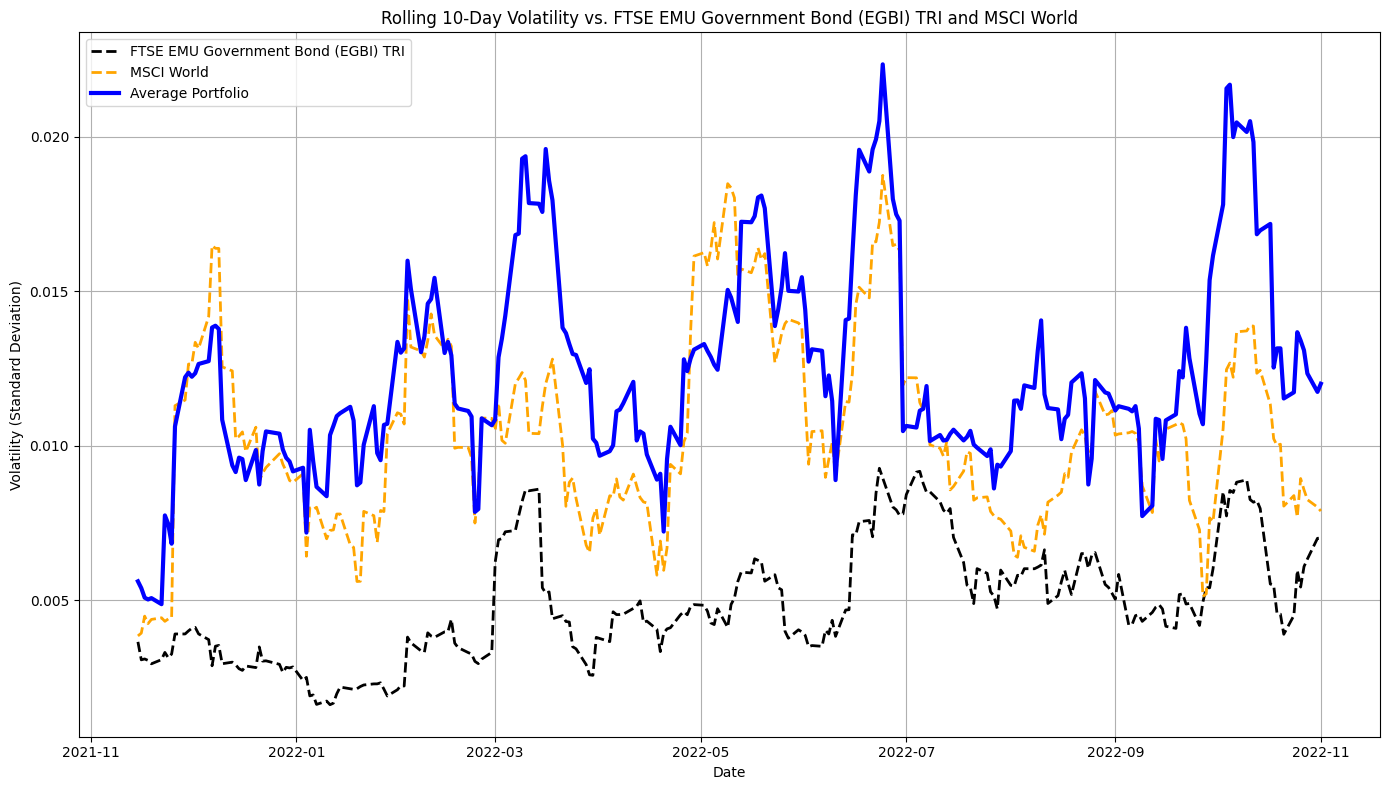

In [215]:
plot_volatility(portfolios, show_average_only=True, window=10)